<a href="https://colab.research.google.com/github/conwayjw97/ImageColourizationModels/blob/master/src/DeterministicConvNetCifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Global Variables

In [0]:
IMAGE_COUNT = 50000
TRAINING_IMAGE = 0
TEST_IMAGE = 0
BATCH_SIZE = 1000
CLASSIFICATION_EPOCHS = 30
COLOURISATION_EPOCHS = 100
LOAD_CLASSIFICATION_MODEL = True
LOAD_COLOURISATION_MODEL = False

# Import Statements

In [40]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

#%load_ext tensorboard

import tensorflow as tf
import datetime, os
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.ndimage.filters import gaussian_filter1d
from tensorflow.keras import datasets, layers, models, backend, utils, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

drive.mount("/content/gdrive", force_remount=True)
base_dir = "/content/gdrive/My Drive/DeterministicConvNetCifar10/"

Mounted at /content/gdrive


# Load Dataset

In [0]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()
train_images = train_images / 255.0
test_images = test_images / 255.0

# def scale_pixels(train, test):
# 	# convert from integers to floats
# 	train_norm = train.astype('float32')
# 	test_norm = test.astype('float32')
# 	# normalize to range 0-1
# 	train_norm = train_norm / 255.0
# 	test_norm = test_norm / 255.0
# 	# return normalized images
# 	return train_norm, test_norm

# images = np.append(train_images[:4], np.flip(train_images[:4], axis=2), axis=0)
# fig = plt.figure(figsize=(25, 16))
# for i in range(8):
#   fig.add_subplot(1,8,i+1)
#   plt.imshow(images[i])

# datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=45)
# plot(datagen)

# def imageLoader(images, batch_size):
#     #datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=45)
#     # Keras needs the generator to loop infinitely
#     while True:
#         batch_start = 0
#         batch_end = batch_size
#         while batch_start < len(images):
#             limit = min(batch_end, len(images))
#             # Append mirrored images
#             X = np.append(tf.expand_dims(images[batch_start:limit,:,:,0], 3), np.flip(tf.expand_dims(images[batch_start:limit,:,:,0], 3), axis=2), axis=0)
#             Y = np.append(images[batch_start:limit,:,:,1:], np.flip(images[batch_start:limit,:,:,1:], axis=2), axis=0)
#             yield (X,Y)   
#             #print("\nLoading batch of images: ", batch_start, " - ", batch_end)
#             batch_start += batch_size   
#             batch_end += batch_size

def train_image_loader(images, batch_size):
  x_train = tf.expand_dims(images[:,:,:,0], 3)
  y_train = images[:,:,:,1:]
  datagen = ImageDataGenerator(horizontal_flip=True, rotation_range=45, width_shift_range=0.1, brightness_range=(0.8, 1.0), zoom_range=[0.5, 1.5])
  datagen.fit(x_train)
  # Keras needs the generator to loop infinitely
  while True:
    #count = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=batch_size):
      #print("\ncount: ", count, " - x_batch.shape: ", x_batch.shape, " - y_batch.shape: ", y_batch.shape)
      yield (x_batch, y_batch)  
      #count+=1

def test_image_loader(images, batch_size):
  x_train = tf.expand_dims(images[:,:,:,0], 3)
  y_train = images[:,:,:,1:]
  datagen = ImageDataGenerator()
  # Keras needs the generator to loop infinitely
  while True:
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=batch_size):
      yield (x_batch, y_batch)  

# Convert to Grayscale

In [0]:
train_gray_images = tf.image.rgb_to_grayscale(train_images[:IMAGE_COUNT])
test_gray_images = tf.image.rgb_to_grayscale(test_images[:IMAGE_COUNT])

# Create the Classification CNN



In [56]:
# 3-block vgg style architecture
# https://arxiv.org/abs/1409.1556
def create_classification_model():
  model = models.Sequential()
  # Feature detection layers
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 1)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(layers.MaxPooling2D((2, 2)))
  # Classifier layers
  model.add(layers.Flatten())
  model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.Dense(10, activation='softmax'))
  opt = optimizers.SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

create_classification_model().summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_114 (Conv2D)          (None, 32, 32, 32)        320       
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_116 (Conv2D)          (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_117 (Conv2D)          (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_58 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_118 (Conv2D)          (None, 8, 8, 128)       

# Train the Classification Model

In [59]:
model = create_classification_model()

checkpoint_path = "classification.ckpt"
checkpoint_dir = os.path.dirname(base_dir + checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir, verbose=1)
print(checkpoint_dir)
if(LOAD_MODEL):
  model.load_weights(checkpoint_dir)
  total_loss, total_accuracy = model.evaluate(test_gray_images, utils.to_categorical(test_labels), verbose=2)
  total_loss = np.array(total_loss)
  total_accuracy = np.array(total_accuracy)
else:
  history = model.fit(train_gray_images, utils.to_categorical(train_labels), epochs=30, batch_size=64, validation_data=(test_gray_images, utils.to_categorical(test_labels)))
  model.save_weights(checkpoint_dir)
  total_loss = history.history["loss"]
  total_val_loss = history.history["val_loss"]
  total_accuracy = history.history["accuracy"]
  total_val_accuracy = history.history["val_accuracy"]

/content/gdrive/My Drive/DeterministicConvNetCifar10
Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 6s 116us/sample - loss: 1.8558 - accuracy: 0.3364 - val_loss: 1.5899 - val_accuracy: 0.4278
Epoch 2/30
50000/50000 [==============================] - 5s 103us/sample - loss: 1.4902 - accuracy: 0.4750 - val_loss: 1.3898 - val_accuracy: 0.5119
Epoch 3/30
50000/50000 [==============================] - 5s 104us/sample - loss: 1.3117 - accuracy: 0.5434 - val_loss: 1.2771 - val_accuracy: 0.5527
Epoch 4/30
50000/50000 [==============================] - 5s 104us/sample - loss: 1.1761 - accuracy: 0.5930 - val_loss: 1.2167 - val_accuracy: 0.5746
Epoch 5/30
50000/50000 [==============================] - 5s 104us/sample - loss: 1.0745 - accuracy: 0.6283 - val_loss: 1.1171 - val_accuracy: 0.6179
Epoch 6/30
50000/50000 [==============================] - 5s 105us/sample - loss: 0.9813 - accuracy: 0.6622 - val_loss: 1.0608 - val_accuracy: 0.63

# Classification Diagnostic Learning Curves

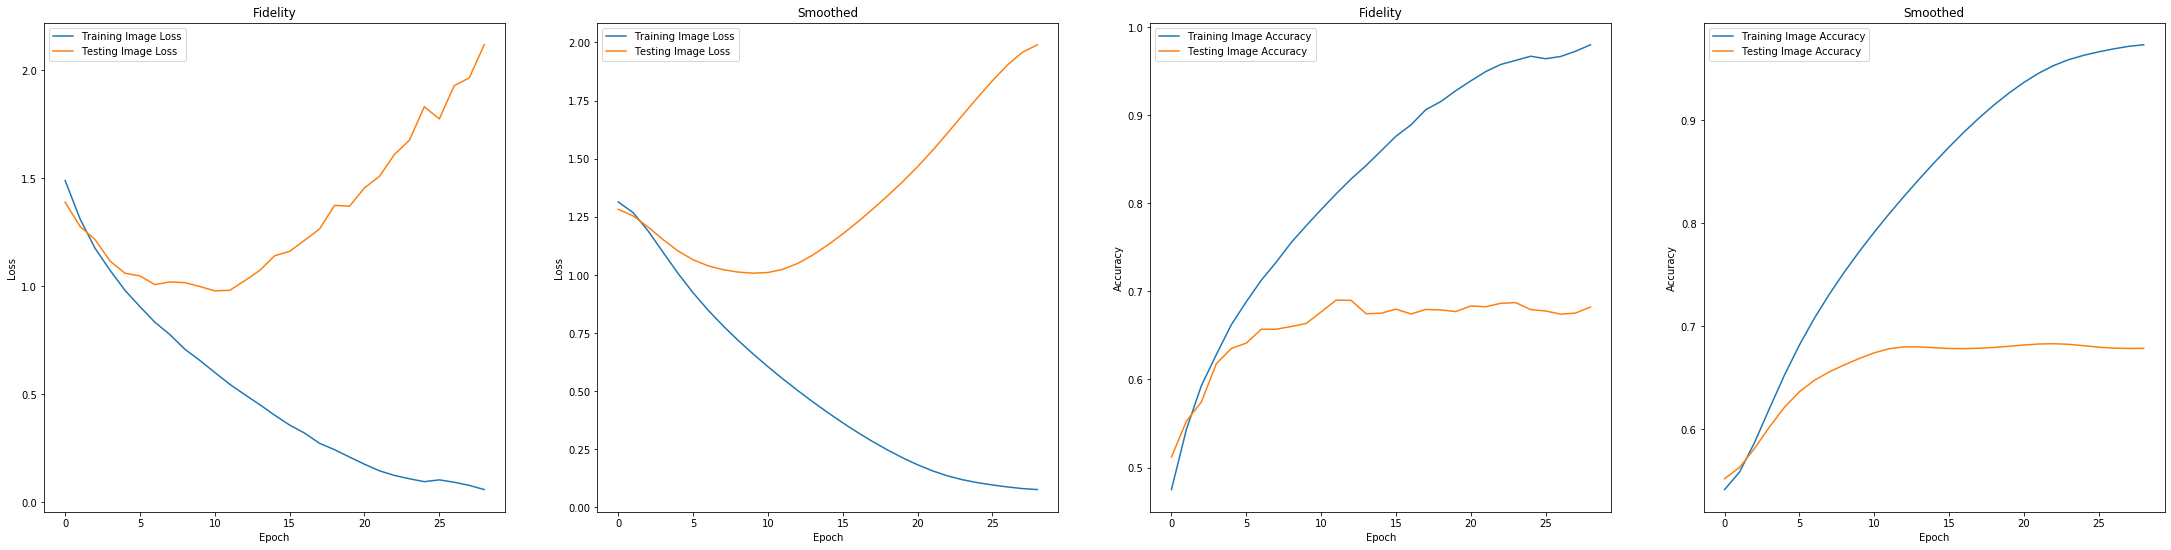

In [60]:
fig = plt.figure(figsize=(38, 9))
fig.add_subplot(1,4,1)
plt.title("Fidelity")
plt.plot(total_loss[1:], label="Training Image Loss")
plt.plot(total_val_loss[1:], label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
fig.add_subplot(1,4,2)
plt.title("Smoothed")
plt.plot(gaussian_filter1d(total_loss[1:], sigma=2), label="Training Image Loss")
plt.plot(gaussian_filter1d(total_val_loss[1:], sigma=2), label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
fig.add_subplot(1,4,3)
plt.title("Fidelity")
plt.plot(total_accuracy[1:], label="Training Image Accuracy")
plt.plot(total_val_accuracy[1:], label="Testing Image Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
fig.add_subplot(1,4,4)
plt.title("Smoothed")
plt.plot(gaussian_filter1d(total_accuracy[1:], sigma=2), label="Training Image Accuracy")
plt.plot(gaussian_filter1d(total_val_accuracy[1:], sigma=2), label="Testing Image Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Classification Results

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

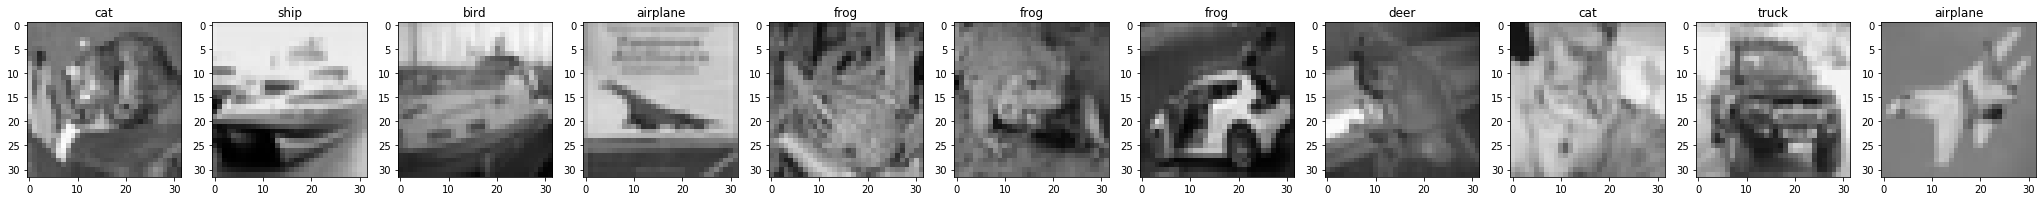

In [70]:
print(model.evaluate(test_grey_images, utils.to_categorical(test_labels), batch_size=BATCH_SIZE))
output = model.predict(test_grey_images)

image_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

output_count = 11

fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  result = model.predict_classes(tf.expand_dims(test_grey_images[i], 0))
  fig.add_subplot(1,output_count,i+1)
  plt.title(image_labels[int(result)])
  plt.imshow(tf.image.grayscale_to_rgb(test_grey_images[i]))

# Convert Images to YUV

In [0]:
# Outputs a tensor of the same shape as the images tensor, containing the YUV 
# value of the pixels. The output is only well defined if the value in images 
# are in [0,1].
#https://zhengtq.github.io/2018/12/27/tensorflow-disturb-yuv/

train_yuvImages = tf.image.rgb_to_yuv(train_images[:IMAGE_COUNT])
train_y = tf.expand_dims(train_yuvImages[:,:,:,0], 3)
train_uv = train_yuvImages[:,:,:,1:]

test_yuvImages = tf.image.rgb_to_yuv(test_images[:IMAGE_COUNT])
test_y = tf.expand_dims(test_yuvImages[:,:,:,0], 3)
test_uv = test_yuvImages[:,:,:,1:]

# Create the Colourisation CNN

In [0]:
# Conv2D(filters (number of output filters)
#           - determine parameter number
#        kernel_size (size of convolution window)
#        activation (activation function to use)
#        padding ("valid" or "same")
#        strides (strides of the convolution along the height and width)
#           - strides greater than 1 will downsample
#        input_shape (only used on the first layer of the model))
#
# UpSampling2D(size (upsampling factors for rows and columns))

#https://github.com/emilwallner/Coloring-greyscale-images

# For an odd-sized filter, all the previous layer pixels would be symmetrically 
# around the output pixel. If you think of convolution as an interpolation from 
# the given pixels to a center pixel, we cannot interpolate to a center pixel 
# using an even-sized filter.

def create_model_very_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def create_model_mid1_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def create_model_mid15_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def create_model_mid2_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def create_model_mid25_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def create_model_mid3_shallow():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def create_model_mid():
  model = models.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  return model

def create_model_deep():
  model = models.Sequential()
  model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  return model

# create_model_very_shallow().summary()
# create_model_mid1_shallow().summary()
# create_model_mid2_shallow().summary()
# create_model_mid3_shallow().summary()
create_model_mid().summary()
# create_model_deep().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 64)        36928     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 256)         295168    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 4, 4, 256)         590080    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 128)         2

In [0]:
def create_model_bottleneck1():
  model = models.Sequential()
  model.add(layers.Conv2D(16, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(4, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

def create_model_bottleneck2():
  model = models.Sequential()
  model.add(layers.Conv2D(64, (2, 2), activation='relu', input_shape=(train_uv.shape[1], train_uv.shape[2], 1)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2))
  model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.UpSampling2D((2, 2)))
  model.add(layers.Conv2D(2, (3, 3), activation='tanh', padding='same'))
  return model

create_model_bottleneck2().summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 31, 31, 64)        320       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 8, 8, 32)          18464     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 32)          9248      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 4, 4, 16)          4624      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 32)         


# Train the Colourisation Model

In [0]:
# fit(x (input data)
#     y (target data)
#     batch_size (samples per gradient update)
#        - smaller batch size = more stochastic
#     epochs (epochs to train the model))

#https://stackoverflow.com/questions/47200146/keras-load-images-batch-wise-for-large-dataset

model = create_model_mid()
model.compile(optimizer='rmsprop',
              loss='mse')

runtime_epochs = int(EPOCHS/4)
total_loss = []
total_val_loss = []
total_accuracy = []
total_val_accuracy = []

history = model.fit_generator(train_image_loader(train_yuvImages, BATCH_SIZE), steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_image_loader(test_yuvImages, BATCH_SIZE)), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
total_loss += history.history["loss"]
total_val_loss += history.history["val_loss"]
total_accuracy += history.history["accuracy"]
total_val_accuracy += history.history["val_accuracy"]

Epoch 1/250
50/50 [==============================] - 20s 402ms/step - loss: 0.0407 - val_loss: 0.0037
Epoch 2/250
50/50 [==============================] - 18s 369ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 3/250
50/50 [==============================] - 18s 368ms/step - loss: 0.0037 - val_loss: 0.0036
Epoch 4/250
50/50 [==============================] - 19s 374ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 5/250
50/50 [==============================] - 18s 370ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 6/250
50/50 [==============================] - 19s 372ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 7/250
50/50 [==============================] - 19s 370ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 8/250
50/50 [==============================] - 19s 377ms/step - loss: 0.0036 - val_loss: 0.0036
Epoch 9/250
50/50 [==============================] - 19s 375ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 10/250
50/50 [==============================] - 19s 370ms/step - loss: 0.003

In [0]:
#history = model.fit(x=train_y, y=train_uv, validation_data=(test_y, test_uv), batch_size=BATCH_SIZE, epochs=runtime_epochs)
history = model.fit_generator(train_image_loader(train_yuvImages, BATCH_SIZE), steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_image_loader(test_yuvImages, BATCH_SIZE)), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
total_loss += history.history["loss"]
total_val_loss += history.history["val_loss"]
total_accuracy += history.history["accuracy"]
total_val_accuracy += history.history["val_accuracy"]

In [0]:
#history = model.fit(x=train_y, y=train_uv, validation_data=(test_y, test_uv), batch_size=BATCH_SIZE, epochs=runtime_epochs)
history = model.fit_generator(train_image_loader(train_yuvImages, BATCH_SIZE), steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_image_loader(test_yuvImages, BATCH_SIZE)), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
total_loss += history.history["loss"]
total_val_loss += history.history["val_loss"]
total_accuracy += history.history["accuracy"]
total_val_accuracy += history.history["val_accuracy"]

In [0]:
#history = model.fit(x=train_y, y=train_uv, validation_data=(test_y, test_uv), batch_size=BATCH_SIZE, epochs=runtime_epochs)
history = model.fit_generator(train_image_loader(train_yuvImages, BATCH_SIZE), steps_per_epoch=int(train_yuvImages.shape[0]/BATCH_SIZE), epochs=runtime_epochs, validation_data=(test_image_loader(test_yuvImages, BATCH_SIZE)), validation_steps=int(test_yuvImages.shape[0]/BATCH_SIZE))
total_loss += history.history["loss"]
total_val_loss += history.history["val_loss"]
total_accuracy += history.history["accuracy"]
total_val_accuracy += history.history["val_accuracy"]

# Colourisation Diagnostic Learning Curves

In [0]:
fig = plt.figure(figsize=(18, 9))
fig.add_subplot(1,2,1)
plt.title("Fidelity")
plt.plot(total_loss[1:], label="Training Image Loss")
plt.plot(total_val_loss[1:], label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
fig.add_subplot(1,2,2)
plt.title("Smoothed")
plt.plot(gaussian_filter1d(total_loss[1:], sigma=2), label="Training Image Loss")
plt.plot(gaussian_filter1d(total_val_loss[1:], sigma=2), label="Testing Image Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

fig = plt.figure(figsize=(18, 9))
fig.add_subplot(1,2,1)
plt.title("Fidelity")
plt.plot(total_accuracy[1:], label="Training Image Accuracy")
plt.plot(total_val_accuracy[1:], label="Testing Image Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
fig.add_subplot(1,2,2)
plt.title("Smoothed Training and Testing Loss over Epochs")
plt.plot(gaussian_filter1d(total_accuracy[1:], sigma=2), label="Training Image Accuracy")
plt.plot(gaussian_filter1d(total_val_accuracy[1:], sigma=2), label="Testing Image Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

NameError: ignored

# Training Results

In [0]:
print(model.evaluate(train_y, train_uv, batch_size=BATCH_SIZE))
output = model.predict(train_y)
result = np.zeros((IMAGE_COUNT, 32, 32, 3))
result[:,:,:,0] = train_y[:,:,:,0]
result[:,:,:,1:] = output

output_count = 11

fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(train_y[TRAINING_IMAGE+i]))

fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(train_images[TRAINING_IMAGE+i])

fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[TRAINING_IMAGE+i]))
  
fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(train_yuvImages[TRAINING_IMAGE+i,:,:,2])
  
fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[TRAINING_IMAGE+i,:,:,2])

# Testing Results

In [0]:
print(model.evaluate(test_y, test_uv, batch_size=BATCH_SIZE))
output = model.predict(test_y)
result = np.zeros((test_yuvImages.shape[0], 32, 32, 3))
result[:,:,:,0] = test_y[:,:,:,0]
result[:,:,:,1:] = output
  
output_count = 11

fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Input")
  plt.imshow(tf.image.grayscale_to_rgb(test_y[TEST_IMAGE+i]))

fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Original")
  plt.imshow(test_images[TEST_IMAGE+i])

fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("Output")
  plt.imshow(tf.image.yuv_to_rgb(result[TEST_IMAGE+i]))
  
fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U original")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("U output")
  plt.imshow(result[TEST_IMAGE+i,:,:,1])
  
fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V original")
  plt.imshow(test_yuvImages[TEST_IMAGE+i,:,:,2])
  
fig = plt.figure(figsize=(36, 16))
for i in range(output_count):
  fig.add_subplot(1,output_count,i+1)
  plt.title("V output")
  plt.imshow(result[TEST_IMAGE+i,:,:,2])

# Layers activation visualization

In [0]:
#https://github.com/gabrielpierobon/cnnshapes/blob/master/README.md
layer_outputs = [layer.output for layer in model.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input
activations = activation_model.predict(test_y) # Returns a list of five Numpy arrays: one array per layer activation

layer_names = []
for layer in model.layers[:12]:
  layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

images_per_row = 9

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
  n_features = layer_activation.shape[-1] # Number of features in the feature map
  size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
  n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  for col in range(n_cols): # Tiles each filter into a big horizontal grid
    for row in range(images_per_row):
      channel_image = layer_activation[0,:, :,col * images_per_row + row]
      channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')